In [ ]:
from typing import TypedDict, Literal, Annotated

In [ ]:
import os
import dotenv
from google.colab import drive

dotenv.load_dotenv('/content/drive/MyDrive/.env')
print(os.environ.get('GOOGLE_API_KEY'))
print(os.environ.get('LANGSMITH_API_KEY'))

In [ ]:
class PortfolioState(TypedDict):
  amount_usd: float
  total_usd: float
  total_inr: float

In [ ]:
def calc_total(state: PortfolioState) -> PortfolioState:
  state['total_usd'] = state['amount_usd']*1.08
  return state

In [ ]:
def convert_to_inr(state: PortfolioState) -> PortfolioState:
  state['total_inr'] = state['total_usd']*85
  return state

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

# Add nodes
builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

# Add edges
builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

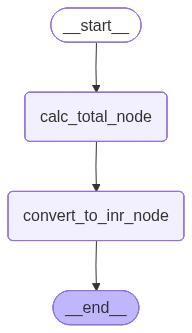

In [ ]:
# Display graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

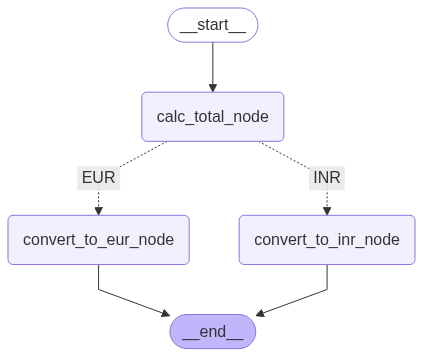

In [ ]:
class PortfolioState(TypedDict):
  amount_usd: float
  total_usd: float
  target_currency: Literal["USD", "EUR"]
  total: float

def calc_total(state: PortfolioState) -> PortfolioState:
  state['total_usd'] = state['amount_usd']*1.08
  return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
  state['total'] = state['total_usd']*85
  return state

def convert_to_eur(state: PortfolioState) -> PortfolioState:
  state['total'] = state['total_usd']*0.9
  return state

def choose_conversion(state: PortfolioState) -> PortfolioState:
  return state["target_currency"]


builder = StateGraph(PortfolioState)

# Add nodes
builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)
builder.add_node("convert_to_eur_node", convert_to_eur)

# Add edges
builder.add_edge(START, "calc_total_node")
builder.add_conditional_edges(
    "calc_total_node",
    choose_conversion,
    {
        "INR":"convert_to_inr_node",
        "EUR":"convert_to_eur_node",
    }
)
builder.add_edge(["convert_to_inr_node", "convert_to_eur_node"], END)

graph = builder.compile()

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"amount_usd": 1000, "target_currency": "INR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'INR',
 'total': 91800.0}

In [ ]:
graph.invoke({"amount_usd": 1000, "target_currency": "EUR"})

{'amount_usd': 1000,
 'total_usd': 1080.0,
 'target_currency': 'EUR',
 'total': 972.0}

In [ ]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm.invoke("Who is the father of AI?")

AIMessage(content='The title "father of AI" is often attributed to **Alan Turing**.\n\nWhile many individuals contributed significantly to the early development of AI, Turing\'s contributions are particularly foundational and influential:\n\n*   **Turing Machine:** His theoretical model of computation, the Turing Machine, provided a blueprint for how computers could process information, laying the groundwork for the possibility of artificial intelligence.\n*   **Turing Test:** He proposed the Turing Test as a way to assess whether a machine could exhibit intelligent behavior indistinguishable from that of a human. This test continues to be a benchmark and a source of debate in the field.\n*   **Early AI Thinking:** Turing also explored the philosophical and practical aspects of creating thinking machines in his seminal paper "Computing Machinery and Intelligence" (1950).\n\nAlthough other figures like John McCarthy (who coined the term "artificial intelligence"), Marvin Minsky, Claude 

In [ ]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
  messages: Annotated[list, add_messages]

def chatbot(state: State) -> State:
  return {"messages":[llm.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)

builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

In [ ]:
message = {"role":"user",
           "content":"How Far are we from AGI?"
           }

response = graph.invoke({"messages":[message]})
response["messages"]

[AIMessage(content='The question of how far we are from Artificial General Intelligence (AGI) is one of the most debated and uncertain topics in the field of AI. There\'s no consensus, and estimates range wildly. Here\'s a breakdown of the factors contributing to the uncertainty and different perspectives:\n\n**What is AGI?**\n\nFirst, it\'s important to define AGI.  AGI refers to an AI system that:\n\n*   **Understands:** Possesses a general understanding of the world and can reason about it.\n*   **Learns:** Can learn new skills and knowledge across a wide range of domains, much like a human.\n*   **Adapts:** Can apply its knowledge and skills to novel situations and solve problems it hasn\'t been explicitly trained for.\n*   **Generalizes:** Can transfer learning from one domain to another.\n*   **Exhibits Common Sense:** Possesses the implicit knowledge about the world that humans take for granted.\n\n**Why is it so hard to predict?**\n\n*   **Lack of a Clear Roadmap:** We don\'t h

In [ ]:
state = None
while True:
  in_message = input("You: ")
  if in_message.lower() in {"quit", "exit"}:
    break
  if state is None:
    state: State={
        "messages":[{
            "role":"user",
            "content":in_message
        }]
    }
  else:
    state["messages"].append({"role":"user", "content":in_message})

state = graph.invoke(state)
print("Bot:", state["messages"][-1].content)

You: A person got 57% in 12th science, whereas an another person got 84% in 12th science, what it speaks about the students ?
You: exit
Bot: While the percentages offer some insight, it's crucial to avoid making sweeping generalizations about the students based solely on these numbers. Here's what the percentages *might* indicate, along with important caveats:

**Possible Interpretations:**

* **84% Student (High Achiever):**
    * **Stronger grasp of science concepts:** Likely has a better understanding of the curriculum and can apply it effectively.
    * **Better test-taking skills:**  Potentially more adept at understanding question formats, managing time, and avoiding careless errors.
    * **Higher work ethic/dedication:** May have dedicated more time and effort to studying and completing assignments.
    * **More effective study strategies:**  Might have developed better methods for learning and retaining information.
    * **Potentially more interest in science:**  A genuine in

In [ ]:
from langchain_core.tools import tool

@tool
def get_stock_price(symbol: str) -> float:
  """
  Return the current price of stock for the given symbol.
  """
  return{
      "MSFT":200.3,
      "AAPL":100.4,
      "AMZN":150.0,
      "RIL":87.6
  }.get(symbol, 0.0)

tools = [get_stock_price]
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

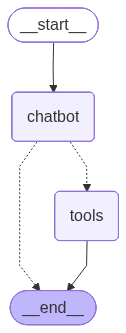

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State) -> State:
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("chatbot", END)

graph = builder.compile()

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
state = graph.invoke({"messages":[{"role":"user", "content":"what is the price of AMZN stock right now?"}]})
state["messages"][-1].content

'150.0'

In [ ]:
state = graph.invoke({"messages":[{"role":"user", "content":"what is the chemical formula for water?"}]})
state["messages"][-1].content

'The chemical formula for water is H2O.'

In [ ]:
# Not performing the calculation
state = graph.invoke({"messages":[{"role":"user", "content":"I want to buy 20 AMZN stocks using current price. Then 15 MSFT, What will be the total cost?"}]})
state["messages"][-1].content

'200.3'

# Making the chatbot Intellignet

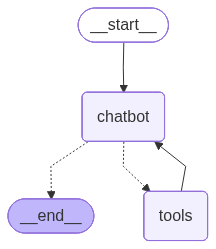

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State) -> State:
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile()

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Now performing the calculation
state = graph.invoke({"messages":[{"role":"user", "content":"I want to buy 20 AMZN stocks using current price. Then 15 MSFT, What will be the total cost?"}]})
state["messages"][-1].content

'OK. The current price for AMZN is $150 and for MSFT is $200.3.\nThe total cost for 20 AMZN stocks is 20 * $150 = $3000.\nThe total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.\nTherefore, the total cost for both is $3000 + $3004.5 = $6004.5.'

In [ ]:
# No memory component in our agent currently
state = graph.invoke({"messages":[{"role":"user", "content":"Using the current price tell me the total price of 10 RIL stocks and add it to previous total"}]})
state["messages"][-1].content

"I can get the current price of RIL stock for you. However, I don't have the information about your previous total. Could you please provide the previous total, so I can calculate the new total for you."

# Adding memory component in our agent

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

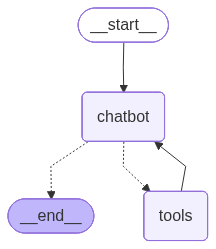

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition

def chatbot(state: State) -> State:
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)

graph = builder.compile(checkpointer=memory)

# Display graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Now performing the calculation
config = {'configurable':{'thread_id':'1'}}

state = graph.invoke({"messages":[{"role":"user", "content":"I want to buy 20 AMZN stocks using current price. Then 15 MSFT, What will be the total cost?"}]}, config=config)
state["messages"][-1].content

'OK. The current price for AMZN is $150 and for MSFT is $200.3.\nThe total cost for 20 AMZN stocks is 20 * $150 = $3000.\nThe total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.\nTherefore, the total cost for both is $3000 + $3004.5 = $6004.5.'

In [ ]:
# No memory component in our agent currently
state = graph.invoke({"messages":[{"role":"user", "content":"Using the current price tell me the total price of 10 RIL stocks and add it to previous total"}]}, config=config)
state["messages"][-1].content

'OK. The current price for RIL is $87.6.\nThe total cost for 10 RIL stocks is 10 * $87.6 = $876.\nAdding this to the previous total of $6004.5, the new total is $6004.5 + $876 = $6880.5.'

In [ ]:
# Now performing the calculation
config1 = {'configurable':{'thread_id':'2'}}

state = graph.invoke({"messages":[{"role":"user", "content":"Tell me the current price of 5 AAPL stocks"}]}, config=config1)
state["messages"][-1].content

'The current price of one AAPL stock is $100.4. Therefore, the current price of 5 AAPL stocks is $502.'

In [ ]:
state = graph.invoke({"messages":[{"role":"user", "content":"Tell me the current price of 5 MSFT stocks and add it to previous total"}]}, config=config1)
state["messages"][-1].content

'The current price of one MSFT stock is $200.3. Therefore, the current price of 5 MSFT stocks is $1001. Adding this to the previous total of $502, the new total is $1503.'

https://smith.langchain.com -> Home -> Set up tracing -> Generate API key -> Copy configure env code -> add it in your .env file

# LangSmith

In [ ]:
!pip install langsmith

In [ ]:
from langsmith import traceable

@traceable
def call_graph(query: str):
  state = graph.invoke({"messages":[{"role":"user", "content":query}]})
  print(state["messages"][-1].content)


call_graph("I want to buy 20 AMZN stocks using current price. Then 15 MSFT, What will be the total cost?")

OK. The current price for AMZN is $150 and for MSFT is $200.3.
The total cost for 20 AMZN stocks is 20 * $150 = $3000.
The total cost for 15 MSFT stocks is 15 * $200.3 = $3004.5.
So, the total cost for both is $3000 + $3004.5 = $6004.5.


# New

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from typing import Annotated


class State(TypedDict):
  messages: Annotated[list, add_messages]


@tool
def get_stock_price(symbol: str) -> float:
  """ Return the current price of stock for the given symbol."""
  return{
      "MSFT":200.3,
      "AAPL":100.4,
      "AMZN":150.0,
      "RIL":87.6
  }.get(symbol, 0.0)

@tool
def buy_stocks(symbol:str, quantity:int, total_price:float) -> str:
  """Buy stocks given the stock symbol and quantity"""
  return f"Yout bought {quantity} shares of {symbol} for {total_price}"

tools = [get_stock_price, buy_stocks]
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot_node(state: State) -> State:
  return {"messages":[llm_with_tools.invoke(state["messages"])]}


memory = MemorySaver()
builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot",tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer=memory)


config = {'configurable':{'thread_id':'buy_thread'}}

# Step 1 :- user asks price
state = graph.invoke({"messages":[{"role":"user", "content":"what is the current price of 10 MSFT stock right now?"}]}, config=config)
print(state["messages"][-1].content)

# Step 2 :- user aks to buy
state = graph.invoke({"messages":[{"role":"user", "content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state["messages"][-1].content)

Could you please provide the stock symbol for Microsoft?
Can you please provide the current total price for 10 MSFT stocks? I need the total price to complete the purchase.
